In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer

In [2]:
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[2] += v[2]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b and x[2]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b and x[2]<b:
            ch = 1.0
            stop = True
        elif x[2]>= b and x[0]<b and x[1]<b:
            ch = 2.0
            stop = True
        elif (x[0]>= b and x[1]>=b) or (x[1]>= b and x[2]>=b) or (x[0]>= b and x[2]>=b):
            rt = 0
            x = np.array([0.0, 0.0, 0.0])
    return rt+ndt, ch

In [3]:
data_df = pd.read_csv('../../_data/Kr2011.csv')
data_df.rename(columns={'subject': 'sbj'}, inplace=True)
data_df['rt'] /= 1000

mean_rt = data_df.groupby('sbj')['rt'].mean()
std_rt = data_df.groupby('sbj')['rt'].std()
RT_Max = mean_rt + 3 * std_rt

rt_max = []
for i in range(data_df.shape[0]):
    rt_max.append(RT_Max[data_df['sbj'][i]])
data_df['rt_max'] = rt_max
data_df = data_df[(data_df['rt']>0.25) & (data_df['rt']<data_df['rt_max'])].reset_index(drop=True)
data_df['sbj'] += 1

data_df['choice_0'] = pd.get_dummies(data_df['choice'])[0]
data_df['choice_1'] = pd.get_dummies(data_df['choice'])[1]
data_df['choice_2'] = pd.get_dummies(data_df['choice'])[2]

mov = (data_df['item_value_0'] + data_df['item_value_1'])/2

data_df['Right Value - Mean Other Value'] = data_df['item_value_2'] - mov
kbins1 = KBinsDiscretizer(n_bins=9, encode='ordinal', strategy='uniform')
data_df['Right Value - Mean Other Value'] = 2*(kbins1.fit_transform(data_df[['Right Value - Mean Other Value']])-4)

data_df['gaze diff'] = data_df['gaze_2'] - (data_df['gaze_0'] + data_df['gaze_1'])
kbins2 = KBinsDiscretizer(n_bins=9, encode='ordinal', strategy='uniform')
data_df['gaze diff'] = kbins2.fit_transform(data_df[['gaze diff']])
mms = MinMaxScaler(feature_range=(-1, 1))
data_df['Dwell Time Advantage (R - O)'] = mms.fit_transform(data_df[['gaze diff']])

min_rt = data_df.groupby(by='sbj')['rt'].min()

In [4]:
tr_df, ts_df = data_df.copy(), data_df.copy()

obs_train = np.asarray(tr_df[['rt', 'choice_0', 'choice_1', 'choice_2']])
X_train = np.asarray(tr_df[['item_value_0', 'item_value_1', 'item_value_2', 
                            'gaze_0', 'gaze_1', 'gaze_2']])

obs_test = np.asarray(ts_df[['rt', 'choice_0', 'choice_1', 'choice_2']])
X_test = np.asarray(ts_df[['item_value_0', 'item_value_1', 'item_value_2', 
                           'gaze_0', 'gaze_1', 'gaze_2']])

print(X_train.shape, X_test.shape)

(2922, 6) (2922, 6)


In [5]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):
    ndt = tf.convert_to_tensor([min_rt[i]*tf.math.sigmoid(model.layers[-1].weights[-1][i-1]) for i in tr_df['sbj']])
    thr = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-2][i-1])) for i in tr_df['sbj']])
    scl = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-3][i-1])) for i in tr_df['sbj']])
    
    ll1 = (obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 1])) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 2]))
    ll2 = (obs_train[:, 2]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 0])) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 2]))
    ll3 = (obs_train[:, 3]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 2]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 0])) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]))
    
    return -2*tf.reduce_sum(tf.math.log(ll1 + ll2 + ll3), axis=-1)

In [6]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=3, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [7]:
layers_neuron = [10, 10, 10, 10]
input_shape = 6
output_shape = 3
activation = 'sigmoid'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                70        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
 out_layer (Out_layer)       (None, 3)                 123       
                                                                 
Total params: 523 (2.04 KB)
Trainable params: 523 (2.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [34]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=5000)

Epoch 1/2500
1/1 [==============================] - 0s 68ms/step - loss: 10854.9766
Epoch 2/2500
1/1 [==============================] - 0s 29ms/step - loss: 10854.0635
Epoch 3/2500
1/1 [==============================] - 0s 31ms/step - loss: 10853.4307
Epoch 4/2500
1/1 [==============================] - 0s 30ms/step - loss: 10852.5225
Epoch 5/2500
1/1 [==============================] - 0s 30ms/step - loss: 10851.3662
Epoch 6/2500
1/1 [==============================] - 0s 30ms/step - loss: 10850.4688
Epoch 7/2500
1/1 [==============================] - 0s 29ms/step - loss: 10849.2432
Epoch 8/2500
1/1 [==============================] - 0s 30ms/step - loss: 10848.3135
Epoch 9/2500
1/1 [==============================] - 0s 29ms/step - loss: 10847.4541
Epoch 10/2500
1/1 [==============================] - 0s 28ms/step - loss: 10846.2227
Epoch 11/2500
1/1 [==============================] - 0s 36ms/step - loss: 10845.0371
Epoch 12/2500
1/1 [==============================] - 0s 30ms/step - loss: 

1/1 [==============================] - 0s 27ms/step - loss: 10756.1221
Epoch 98/2500
1/1 [==============================] - 0s 29ms/step - loss: 10754.1436
Epoch 99/2500
1/1 [==============================] - 0s 29ms/step - loss: 10753.5957
Epoch 100/2500
1/1 [==============================] - 0s 27ms/step - loss: 10751.7383
Epoch 101/2500
1/1 [==============================] - 0s 28ms/step - loss: 10751.2363
Epoch 102/2500
1/1 [==============================] - 0s 28ms/step - loss: 10749.8652
Epoch 103/2500
1/1 [==============================] - 0s 27ms/step - loss: 10748.9570
Epoch 104/2500
1/1 [==============================] - 0s 27ms/step - loss: 10747.6660
Epoch 105/2500
1/1 [==============================] - 0s 28ms/step - loss: 10746.6035
Epoch 106/2500
1/1 [==============================] - 0s 28ms/step - loss: 10745.6211
Epoch 107/2500
1/1 [==============================] - 0s 34ms/step - loss: 10744.6084
Epoch 108/2500
1/1 [==============================] - 0s 27ms/step - lo

1/1 [==============================] - 0s 27ms/step - loss: 10645.3066
Epoch 193/2500
1/1 [==============================] - 0s 35ms/step - loss: 10643.3438
Epoch 194/2500
1/1 [==============================] - 0s 27ms/step - loss: 10642.6250
Epoch 195/2500
1/1 [==============================] - 0s 28ms/step - loss: 10642.1045
Epoch 196/2500
1/1 [==============================] - 0s 27ms/step - loss: 10640.6445
Epoch 197/2500
1/1 [==============================] - 0s 27ms/step - loss: 10640.1465
Epoch 198/2500
1/1 [==============================] - 0s 27ms/step - loss: 10638.4980
Epoch 199/2500
1/1 [==============================] - 0s 26ms/step - loss: 10636.3916
Epoch 200/2500
1/1 [==============================] - 0s 28ms/step - loss: 10635.2598
Epoch 201/2500
1/1 [==============================] - 0s 27ms/step - loss: 10633.3613
Epoch 202/2500
1/1 [==============================] - 0s 27ms/step - loss: 10632.3320
Epoch 203/2500
1/1 [==============================] - 0s 27ms/step - 

1/1 [==============================] - 0s 29ms/step - loss: 10522.8730
Epoch 288/2500
1/1 [==============================] - 0s 28ms/step - loss: 10522.0752
Epoch 289/2500
1/1 [==============================] - 0s 26ms/step - loss: 10521.3574
Epoch 290/2500
1/1 [==============================] - 0s 28ms/step - loss: 10519.2715
Epoch 291/2500
1/1 [==============================] - 0s 28ms/step - loss: 10518.1543
Epoch 292/2500
1/1 [==============================] - 0s 27ms/step - loss: 10516.7246
Epoch 293/2500
1/1 [==============================] - 0s 27ms/step - loss: 10515.0098
Epoch 294/2500
1/1 [==============================] - 0s 27ms/step - loss: 10512.6885
Epoch 295/2500
1/1 [==============================] - 0s 28ms/step - loss: 10512.0430
Epoch 296/2500
1/1 [==============================] - 0s 27ms/step - loss: 10509.9844
Epoch 297/2500
1/1 [==============================] - 0s 28ms/step - loss: 10509.3643
Epoch 298/2500
1/1 [==============================] - 0s 29ms/step - 

1/1 [==============================] - 0s 29ms/step - loss: 10391.9316
Epoch 383/2500
1/1 [==============================] - 0s 31ms/step - loss: 10391.0352
Epoch 384/2500
1/1 [==============================] - 0s 28ms/step - loss: 10388.8623
Epoch 385/2500
1/1 [==============================] - 0s 27ms/step - loss: 10387.9766
Epoch 386/2500
1/1 [==============================] - 0s 27ms/step - loss: 10387.0010
Epoch 387/2500
1/1 [==============================] - 0s 28ms/step - loss: 10384.4395
Epoch 388/2500
1/1 [==============================] - 0s 27ms/step - loss: 10384.3867
Epoch 389/2500
1/1 [==============================] - 0s 27ms/step - loss: 10380.9160
Epoch 390/2500
1/1 [==============================] - 0s 27ms/step - loss: 10380.7285
Epoch 391/2500
1/1 [==============================] - 0s 28ms/step - loss: 10377.0508
Epoch 392/2500
1/1 [==============================] - 0s 28ms/step - loss: 10376.1348
Epoch 393/2500
1/1 [==============================] - 0s 28ms/step - 

1/1 [==============================] - 0s 30ms/step - loss: 10251.5703
Epoch 478/2500
1/1 [==============================] - 0s 28ms/step - loss: 10251.0996
Epoch 479/2500
1/1 [==============================] - 0s 27ms/step - loss: 10250.1289
Epoch 480/2500
1/1 [==============================] - 0s 27ms/step - loss: 10247.8701
Epoch 481/2500
1/1 [==============================] - 0s 27ms/step - loss: 10245.8193
Epoch 482/2500
1/1 [==============================] - 0s 27ms/step - loss: 10244.0654
Epoch 483/2500
1/1 [==============================] - 0s 27ms/step - loss: 10244.8203
Epoch 484/2500
1/1 [==============================] - 0s 27ms/step - loss: 10243.9902
Epoch 485/2500
1/1 [==============================] - 0s 27ms/step - loss: 10240.3867
Epoch 486/2500
1/1 [==============================] - 0s 28ms/step - loss: 10238.4883
Epoch 487/2500
1/1 [==============================] - 0s 27ms/step - loss: 10238.0430
Epoch 488/2500
1/1 [==============================] - 0s 27ms/step - 

1/1 [==============================] - 0s 28ms/step - loss: 10093.5791
Epoch 573/2500
1/1 [==============================] - 0s 28ms/step - loss: 10091.7646
Epoch 574/2500
1/1 [==============================] - 0s 28ms/step - loss: 10089.3086
Epoch 575/2500
1/1 [==============================] - 0s 27ms/step - loss: 10089.3994
Epoch 576/2500
1/1 [==============================] - 0s 28ms/step - loss: 10086.1455
Epoch 577/2500
1/1 [==============================] - 0s 27ms/step - loss: 10083.9766
Epoch 578/2500
1/1 [==============================] - 0s 28ms/step - loss: 10084.4004
Epoch 579/2500
1/1 [==============================] - 0s 28ms/step - loss: 10081.6680
Epoch 580/2500
1/1 [==============================] - 0s 28ms/step - loss: 10081.0908
Epoch 581/2500
1/1 [==============================] - 0s 29ms/step - loss: 10078.2998
Epoch 582/2500
1/1 [==============================] - 0s 28ms/step - loss: 10075.1357
Epoch 583/2500
1/1 [==============================] - 0s 28ms/step - 

Epoch 668/2500
1/1 [==============================] - 0s 30ms/step - loss: 9913.1768
Epoch 669/2500
1/1 [==============================] - 0s 29ms/step - loss: 9912.5176
Epoch 670/2500
1/1 [==============================] - 0s 29ms/step - loss: 9912.4375
Epoch 671/2500
1/1 [==============================] - 0s 31ms/step - loss: 9907.7500
Epoch 672/2500
1/1 [==============================] - 0s 32ms/step - loss: 9905.7266
Epoch 673/2500
1/1 [==============================] - 0s 30ms/step - loss: 9903.4121
Epoch 674/2500
1/1 [==============================] - 0s 28ms/step - loss: 9902.0527
Epoch 675/2500
1/1 [==============================] - 0s 28ms/step - loss: 9900.9580
Epoch 676/2500
1/1 [==============================] - 0s 30ms/step - loss: 9900.5625
Epoch 677/2500
1/1 [==============================] - 0s 38ms/step - loss: 9898.4727
Epoch 678/2500
1/1 [==============================] - 0s 77ms/step - loss: 9899.9238
Epoch 679/2500
1/1 [==============================] - 0s 31ms/ste

1/1 [==============================] - 0s 27ms/step - loss: 9742.4111
Epoch 765/2500
1/1 [==============================] - 0s 27ms/step - loss: 9741.8105
Epoch 766/2500
1/1 [==============================] - 0s 27ms/step - loss: 9742.7070
Epoch 767/2500
1/1 [==============================] - 0s 27ms/step - loss: 9738.5928
Epoch 768/2500
1/1 [==============================] - 0s 27ms/step - loss: 9735.4619
Epoch 769/2500
1/1 [==============================] - 0s 27ms/step - loss: 9733.9443
Epoch 770/2500
1/1 [==============================] - 0s 26ms/step - loss: 9733.3018
Epoch 771/2500
1/1 [==============================] - 0s 27ms/step - loss: 9730.1904
Epoch 772/2500
1/1 [==============================] - 0s 27ms/step - loss: 9725.3037
Epoch 773/2500
1/1 [==============================] - 0s 27ms/step - loss: 9727.6084
Epoch 774/2500
1/1 [==============================] - 0s 27ms/step - loss: 9724.8311
Epoch 775/2500
1/1 [==============================] - 0s 26ms/step - loss: 9723.

1/1 [==============================] - 0s 27ms/step - loss: 9604.0127
Epoch 861/2500
1/1 [==============================] - 0s 27ms/step - loss: 9598.6465
Epoch 862/2500
1/1 [==============================] - 0s 27ms/step - loss: 9602.9160
Epoch 863/2500
1/1 [==============================] - 0s 27ms/step - loss: 9596.5342
Epoch 864/2500
1/1 [==============================] - 0s 27ms/step - loss: 9596.5791
Epoch 865/2500
1/1 [==============================] - 0s 41ms/step - loss: 9594.5576
Epoch 866/2500
1/1 [==============================] - 0s 39ms/step - loss: 9597.5322
Epoch 867/2500
1/1 [==============================] - 0s 41ms/step - loss: 9595.4961
Epoch 868/2500
1/1 [==============================] - 0s 29ms/step - loss: 9591.5996
Epoch 869/2500
1/1 [==============================] - 0s 29ms/step - loss: 9589.2998
Epoch 870/2500
1/1 [==============================] - 0s 27ms/step - loss: 9591.7852
Epoch 871/2500
1/1 [==============================] - 0s 29ms/step - loss: 9588.

1/1 [==============================] - 0s 27ms/step - loss: 9493.7891
Epoch 957/2500
1/1 [==============================] - 0s 27ms/step - loss: nan
Epoch 958/2500
1/1 [==============================] - 0s 26ms/step - loss: 9532.9727
Epoch 959/2500
1/1 [==============================] - 0s 27ms/step - loss: nan
Epoch 960/2500
1/1 [==============================] - 0s 26ms/step - loss: 9496.7998
Epoch 961/2500
1/1 [==============================] - 0s 26ms/step - loss: 9498.6152
Epoch 962/2500
1/1 [==============================] - 0s 30ms/step - loss: 9510.5918
Epoch 963/2500
1/1 [==============================] - 0s 27ms/step - loss: 9503.3467
Epoch 964/2500
1/1 [==============================] - 0s 26ms/step - loss: 9505.1572
Epoch 965/2500
1/1 [==============================] - 0s 26ms/step - loss: 9495.2119
Epoch 966/2500
1/1 [==============================] - 0s 26ms/step - loss: 9493.7236
Epoch 967/2500
1/1 [==============================] - 0s 27ms/step - loss: 9490.7754
Epoch 9

1/1 [==============================] - 0s 29ms/step - loss: nan
Epoch 1053/2500
1/1 [==============================] - 0s 30ms/step - loss: 9411.7666
Epoch 1054/2500
1/1 [==============================] - 0s 28ms/step - loss: 9416.0752
Epoch 1055/2500
1/1 [==============================] - 0s 28ms/step - loss: 9417.5820
Epoch 1056/2500
1/1 [==============================] - 0s 29ms/step - loss: 9413.5264
Epoch 1057/2500
1/1 [==============================] - 0s 27ms/step - loss: 9410.2441
Epoch 1058/2500
1/1 [==============================] - 0s 28ms/step - loss: 9408.1104
Epoch 1059/2500
1/1 [==============================] - 0s 28ms/step - loss: 9409.2617
Epoch 1060/2500
1/1 [==============================] - 0s 28ms/step - loss: 9405.0146
Epoch 1061/2500
1/1 [==============================] - 0s 27ms/step - loss: 9409.5566
Epoch 1062/2500
1/1 [==============================] - 0s 28ms/step - loss: 9405.0889
Epoch 1063/2500
1/1 [==============================] - 0s 28ms/step - loss: 

1/1 [==============================] - 0s 51ms/step - loss: 9367.8936
Epoch 1149/2500
1/1 [==============================] - 0s 70ms/step - loss: 9363.2715
Epoch 1150/2500
1/1 [==============================] - 0s 57ms/step - loss: 9364.8564
Epoch 1151/2500
1/1 [==============================] - 0s 34ms/step - loss: nan
Epoch 1152/2500
1/1 [==============================] - 0s 29ms/step - loss: 9364.8750
Epoch 1153/2500
1/1 [==============================] - 0s 30ms/step - loss: 9359.1846
Epoch 1154/2500
1/1 [==============================] - 0s 39ms/step - loss: 9361.8584
Epoch 1155/2500
1/1 [==============================] - 0s 49ms/step - loss: 9360.6416
Epoch 1156/2500
1/1 [==============================] - 0s 49ms/step - loss: 9358.8525
Epoch 1157/2500
1/1 [==============================] - 0s 118ms/step - loss: 9356.9912
Epoch 1158/2500
1/1 [==============================] - 0s 32ms/step - loss: 9355.9111
Epoch 1159/2500
1/1 [==============================] - 0s 29ms/step - loss:

1/1 [==============================] - 0s 26ms/step - loss: 9326.6729
Epoch 1244/2500
1/1 [==============================] - 0s 26ms/step - loss: 9332.4561
Epoch 1245/2500
1/1 [==============================] - 0s 27ms/step - loss: nan
Epoch 1246/2500
1/1 [==============================] - 0s 26ms/step - loss: 9326.4443
Epoch 1247/2500
1/1 [==============================] - 0s 28ms/step - loss: 9321.9258
Epoch 1248/2500
1/1 [==============================] - 0s 28ms/step - loss: 9321.5244
Epoch 1249/2500
1/1 [==============================] - 0s 27ms/step - loss: 9319.1475
Epoch 1250/2500
1/1 [==============================] - 0s 28ms/step - loss: 9319.0830
Epoch 1251/2500
1/1 [==============================] - 0s 27ms/step - loss: 9318.3174
Epoch 1252/2500
1/1 [==============================] - 0s 28ms/step - loss: 9317.7754
Epoch 1253/2500
1/1 [==============================] - 0s 27ms/step - loss: 9318.4727
Epoch 1254/2500
1/1 [==============================] - 0s 29ms/step - loss: 

1/1 [==============================] - 0s 30ms/step - loss: 9299.6006
Epoch 1340/2500
1/1 [==============================] - 0s 30ms/step - loss: 9296.0586
Epoch 1341/2500
1/1 [==============================] - 0s 29ms/step - loss: 9293.4443
Epoch 1342/2500
1/1 [==============================] - 0s 28ms/step - loss: 9294.4492
Epoch 1343/2500
1/1 [==============================] - 0s 28ms/step - loss: 9296.1309
Epoch 1344/2500
1/1 [==============================] - 0s 27ms/step - loss: 9295.4316
Epoch 1345/2500
1/1 [==============================] - 0s 27ms/step - loss: 9296.3740
Epoch 1346/2500
1/1 [==============================] - 0s 27ms/step - loss: 9290.5039
Epoch 1347/2500
1/1 [==============================] - 0s 27ms/step - loss: 9290.5391
Epoch 1348/2500
1/1 [==============================] - 0s 27ms/step - loss: 9291.6865
Epoch 1349/2500
1/1 [==============================] - 0s 27ms/step - loss: 9291.3027
Epoch 1350/2500
1/1 [==============================] - 0s 26ms/step - 

Epoch 1435/2500
1/1 [==============================] - 0s 30ms/step - loss: 9275.8076
Epoch 1436/2500
1/1 [==============================] - 0s 27ms/step - loss: 9274.8262
Epoch 1437/2500
1/1 [==============================] - 0s 28ms/step - loss: 9274.1504
Epoch 1438/2500
1/1 [==============================] - 0s 27ms/step - loss: 9276.7324
Epoch 1439/2500
1/1 [==============================] - 0s 28ms/step - loss: 9272.7158
Epoch 1440/2500
1/1 [==============================] - 0s 28ms/step - loss: 9274.5732
Epoch 1441/2500
1/1 [==============================] - 0s 28ms/step - loss: 9273.3369
Epoch 1442/2500
1/1 [==============================] - 0s 29ms/step - loss: 9275.2256
Epoch 1443/2500
1/1 [==============================] - 0s 30ms/step - loss: 9274.3760
Epoch 1444/2500
1/1 [==============================] - 0s 29ms/step - loss: 9276.3213
Epoch 1445/2500
1/1 [==============================] - 0s 28ms/step - loss: 9278.7529
Epoch 1446/2500
1/1 [==============================] -

Epoch 1531/2500
1/1 [==============================] - 0s 28ms/step - loss: 9262.0332
Epoch 1532/2500
1/1 [==============================] - 0s 27ms/step - loss: 9266.2461
Epoch 1533/2500
1/1 [==============================] - 0s 27ms/step - loss: 9264.2549
Epoch 1534/2500
1/1 [==============================] - 0s 28ms/step - loss: 9262.5781
Epoch 1535/2500
1/1 [==============================] - 0s 28ms/step - loss: 9258.8164
Epoch 1536/2500
1/1 [==============================] - 0s 27ms/step - loss: 9255.8418
Epoch 1537/2500
1/1 [==============================] - 0s 27ms/step - loss: 9255.6094
Epoch 1538/2500
1/1 [==============================] - 0s 27ms/step - loss: 9256.9365
Epoch 1539/2500
1/1 [==============================] - 0s 27ms/step - loss: 9256.7139
Epoch 1540/2500
1/1 [==============================] - 0s 27ms/step - loss: 9257.2344
Epoch 1541/2500
1/1 [==============================] - 0s 27ms/step - loss: 9255.8037
Epoch 1542/2500
1/1 [==============================] -

1/1 [==============================] - 0s 28ms/step - loss: 9244.0576
Epoch 1628/2500
1/1 [==============================] - 0s 28ms/step - loss: 9250.2324
Epoch 1629/2500
1/1 [==============================] - 0s 28ms/step - loss: 9245.9697
Epoch 1630/2500
1/1 [==============================] - 0s 28ms/step - loss: 9245.3066
Epoch 1631/2500
1/1 [==============================] - 0s 27ms/step - loss: 9245.2402
Epoch 1632/2500
1/1 [==============================] - 0s 28ms/step - loss: 9242.8574
Epoch 1633/2500
1/1 [==============================] - 0s 27ms/step - loss: 9243.3340
Epoch 1634/2500
1/1 [==============================] - 0s 27ms/step - loss: 9243.2246
Epoch 1635/2500
1/1 [==============================] - 0s 27ms/step - loss: 9247.5977
Epoch 1636/2500
1/1 [==============================] - 0s 27ms/step - loss: nan
Epoch 1637/2500
1/1 [==============================] - 0s 28ms/step - loss: 9344.4883
Epoch 1638/2500
1/1 [==============================] - 0s 30ms/step - loss: 

1/1 [==============================] - 0s 28ms/step - loss: 9229.9648
Epoch 1724/2500
1/1 [==============================] - 0s 28ms/step - loss: 9238.8389
Epoch 1725/2500
1/1 [==============================] - 0s 28ms/step - loss: 9243.9600
Epoch 1726/2500
1/1 [==============================] - 0s 27ms/step - loss: 9238.2930
Epoch 1727/2500
1/1 [==============================] - 0s 27ms/step - loss: nan
Epoch 1728/2500
1/1 [==============================] - 0s 27ms/step - loss: 9234.3848
Epoch 1729/2500
1/1 [==============================] - 0s 27ms/step - loss: 9232.9189
Epoch 1730/2500
1/1 [==============================] - 0s 27ms/step - loss: 9232.6152
Epoch 1731/2500
1/1 [==============================] - 0s 27ms/step - loss: nan
Epoch 1732/2500
1/1 [==============================] - 0s 27ms/step - loss: 9234.6982
Epoch 1733/2500
1/1 [==============================] - 0s 27ms/step - loss: 9236.4170
Epoch 1734/2500
1/1 [==============================] - 0s 27ms/step - loss: 9233.1

1/1 [==============================] - 0s 29ms/step - loss: 9221.2217
Epoch 1821/2500
1/1 [==============================] - 0s 29ms/step - loss: 9220.9805
Epoch 1822/2500
1/1 [==============================] - 0s 29ms/step - loss: 9222.7148
Epoch 1823/2500
1/1 [==============================] - 0s 31ms/step - loss: 9221.7617
Epoch 1824/2500
1/1 [==============================] - 0s 31ms/step - loss: 9223.9111
Epoch 1825/2500
1/1 [==============================] - 0s 29ms/step - loss: 9222.7510
Epoch 1826/2500
1/1 [==============================] - 0s 29ms/step - loss: 9225.8818
Epoch 1827/2500
1/1 [==============================] - 0s 30ms/step - loss: 9220.3945
Epoch 1828/2500
1/1 [==============================] - 0s 30ms/step - loss: 9221.8086
Epoch 1829/2500
1/1 [==============================] - 0s 30ms/step - loss: 9221.1006
Epoch 1830/2500
1/1 [==============================] - 0s 29ms/step - loss: 9224.0967
Epoch 1831/2500
1/1 [==============================] - 0s 29ms/step - 

1/1 [==============================] - 0s 27ms/step - loss: 9213.6367
Epoch 1916/2500
1/1 [==============================] - 0s 27ms/step - loss: 9210.7373
Epoch 1917/2500
1/1 [==============================] - 0s 26ms/step - loss: 9211.1270
Epoch 1918/2500
1/1 [==============================] - 0s 29ms/step - loss: 9211.3955
Epoch 1919/2500
1/1 [==============================] - 0s 27ms/step - loss: 9212.0293
Epoch 1920/2500
1/1 [==============================] - 0s 28ms/step - loss: 9211.0283
Epoch 1921/2500
1/1 [==============================] - 0s 27ms/step - loss: 9212.0762
Epoch 1922/2500
1/1 [==============================] - 0s 27ms/step - loss: 9213.8369
Epoch 1923/2500
1/1 [==============================] - 0s 27ms/step - loss: 9215.3994
Epoch 1924/2500
1/1 [==============================] - 0s 26ms/step - loss: 9210.6973
Epoch 1925/2500
1/1 [==============================] - 0s 27ms/step - loss: 9214.9756
Epoch 1926/2500
1/1 [==============================] - 0s 26ms/step - 

1/1 [==============================] - 0s 27ms/step - loss: 9237.6582
Epoch 2011/2500
1/1 [==============================] - 0s 27ms/step - loss: 9203.7256
Epoch 2012/2500
1/1 [==============================] - 0s 26ms/step - loss: 9203.3037
Epoch 2013/2500
1/1 [==============================] - 0s 26ms/step - loss: 9203.5498
Epoch 2014/2500
1/1 [==============================] - 0s 27ms/step - loss: 9204.6611
Epoch 2015/2500
1/1 [==============================] - 0s 26ms/step - loss: 9200.4941
Epoch 2016/2500
1/1 [==============================] - 0s 27ms/step - loss: 9203.8027
Epoch 2017/2500
1/1 [==============================] - 0s 26ms/step - loss: 9203.2588
Epoch 2018/2500
1/1 [==============================] - 0s 27ms/step - loss: 9205.6035
Epoch 2019/2500
1/1 [==============================] - 0s 32ms/step - loss: 9203.9395
Epoch 2020/2500
1/1 [==============================] - 0s 28ms/step - loss: 9204.3730
Epoch 2021/2500
1/1 [==============================] - 0s 27ms/step - 

1/1 [==============================] - 0s 28ms/step - loss: 9195.5889
Epoch 2106/2500
1/1 [==============================] - 0s 27ms/step - loss: 9202.6064
Epoch 2107/2500
1/1 [==============================] - 0s 27ms/step - loss: 9201.3008
Epoch 2108/2500
1/1 [==============================] - 0s 28ms/step - loss: 9207.5186
Epoch 2109/2500
1/1 [==============================] - 0s 26ms/step - loss: 9196.5361
Epoch 2110/2500
1/1 [==============================] - 0s 27ms/step - loss: 9199.9512
Epoch 2111/2500
1/1 [==============================] - 0s 28ms/step - loss: 9200.6953
Epoch 2112/2500
1/1 [==============================] - 0s 29ms/step - loss: 9207.8496
Epoch 2113/2500
1/1 [==============================] - 0s 29ms/step - loss: 9200.4023
Epoch 2114/2500
1/1 [==============================] - 0s 29ms/step - loss: 9204.0312
Epoch 2115/2500
1/1 [==============================] - 0s 28ms/step - loss: 9201.2910
Epoch 2116/2500
1/1 [==============================] - 0s 28ms/step - 

1/1 [==============================] - 0s 27ms/step - loss: 9191.7061
Epoch 2201/2500
1/1 [==============================] - 0s 27ms/step - loss: 9193.8398
Epoch 2202/2500
1/1 [==============================] - 0s 26ms/step - loss: 9196.6973
Epoch 2203/2500
1/1 [==============================] - 0s 27ms/step - loss: 9195.7246
Epoch 2204/2500
1/1 [==============================] - 0s 27ms/step - loss: 9195.3799
Epoch 2205/2500
1/1 [==============================] - 0s 27ms/step - loss: 9194.7441
Epoch 2206/2500
1/1 [==============================] - 0s 26ms/step - loss: 9194.7812
Epoch 2207/2500
1/1 [==============================] - 0s 26ms/step - loss: 9195.6055
Epoch 2208/2500
1/1 [==============================] - 0s 27ms/step - loss: 9194.0137
Epoch 2209/2500
1/1 [==============================] - 0s 26ms/step - loss: 9200.7783
Epoch 2210/2500
1/1 [==============================] - 0s 26ms/step - loss: 9193.9775
Epoch 2211/2500
1/1 [==============================] - 0s 27ms/step - 

1/1 [==============================] - 0s 27ms/step - loss: 9188.9580
Epoch 2296/2500
1/1 [==============================] - 0s 27ms/step - loss: 9186.2344
Epoch 2297/2500
1/1 [==============================] - 0s 27ms/step - loss: 9185.0244
Epoch 2298/2500
1/1 [==============================] - 0s 27ms/step - loss: 9188.0850
Epoch 2299/2500
1/1 [==============================] - 0s 28ms/step - loss: 9191.5020
Epoch 2300/2500
1/1 [==============================] - 0s 27ms/step - loss: 9187.0059
Epoch 2301/2500
1/1 [==============================] - 0s 27ms/step - loss: 9187.5596
Epoch 2302/2500
1/1 [==============================] - 0s 27ms/step - loss: 9190.6172
Epoch 2303/2500
1/1 [==============================] - 0s 27ms/step - loss: 9187.8926
Epoch 2304/2500
1/1 [==============================] - 0s 27ms/step - loss: 9186.1836
Epoch 2305/2500
1/1 [==============================] - 0s 27ms/step - loss: 9185.6445
Epoch 2306/2500
1/1 [==============================] - 0s 26ms/step - 

1/1 [==============================] - 0s 41ms/step - loss: 9183.5312
Epoch 2391/2500
1/1 [==============================] - 0s 42ms/step - loss: 9183.4863
Epoch 2392/2500
1/1 [==============================] - 0s 33ms/step - loss: 9186.9785
Epoch 2393/2500
1/1 [==============================] - 0s 31ms/step - loss: 9183.8027
Epoch 2394/2500
1/1 [==============================] - 0s 31ms/step - loss: 9184.8496
Epoch 2395/2500
1/1 [==============================] - 0s 31ms/step - loss: 9184.3730
Epoch 2396/2500
1/1 [==============================] - 0s 31ms/step - loss: 9183.0957
Epoch 2397/2500
1/1 [==============================] - 0s 27ms/step - loss: 9187.5186
Epoch 2398/2500
1/1 [==============================] - 0s 26ms/step - loss: 9183.1162
Epoch 2399/2500
1/1 [==============================] - 0s 27ms/step - loss: 9185.6865
Epoch 2400/2500
1/1 [==============================] - 0s 27ms/step - loss: 9182.6328
Epoch 2401/2500
1/1 [==============================] - 0s 27ms/step - 

1/1 [==============================] - 0s 28ms/step - loss: 9198.0742
Epoch 2486/2500
1/1 [==============================] - 0s 28ms/step - loss: 9184.8223
Epoch 2487/2500
1/1 [==============================] - 0s 33ms/step - loss: 9188.6016
Epoch 2488/2500
1/1 [==============================] - 0s 57ms/step - loss: 9180.5830
Epoch 2489/2500
1/1 [==============================] - 0s 31ms/step - loss: 9177.6172
Epoch 2490/2500
1/1 [==============================] - 0s 29ms/step - loss: 9177.7119
Epoch 2491/2500
1/1 [==============================] - 0s 28ms/step - loss: 9182.0742
Epoch 2492/2500
1/1 [==============================] - 0s 44ms/step - loss: 9181.0322
Epoch 2493/2500
1/1 [==============================] - 0s 32ms/step - loss: 9180.5498
Epoch 2494/2500
1/1 [==============================] - 0s 31ms/step - loss: 9180.2832
Epoch 2495/2500
1/1 [==============================] - 0s 31ms/step - loss: 9185.2100
Epoch 2496/2500
1/1 [==============================] - 0s 30ms/step - 

In [35]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

92/92 [==============================] - 0s 507us/step


In [36]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'value_diff': [],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i-1] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]-1], ndt[ts_df.sbj[s]-1])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['value_diff'].append(ts_df['Right Value - Mean Other Value'][s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - O)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)

In [37]:
pred_bhv['right'] = pd.get_dummies(pred_bhv['ch'])[2]

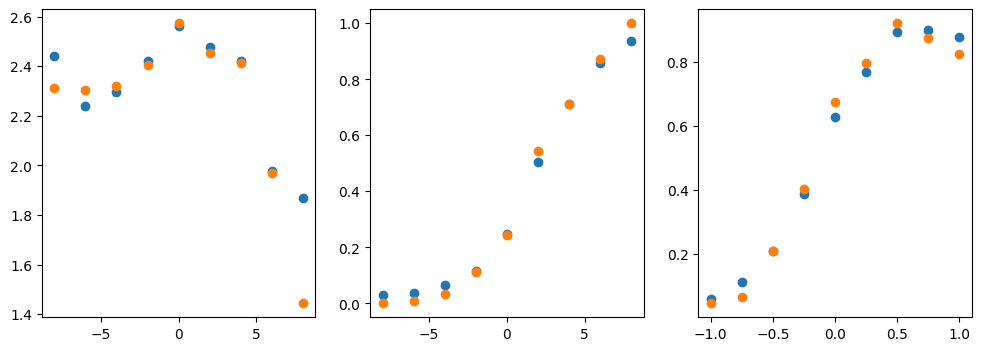

In [38]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(x=pred_bhv.groupby(by='value_diff')['value_diff'].mean(), y=pred_bhv.groupby(by='value_diff')['rt'].mean());
plt.scatter(x=ts_df.groupby(by='Right Value - Mean Other Value')['Right Value - Mean Other Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Mean Other Value')['rt'].mean());

plt.subplot(132)
plt.scatter(x=pred_bhv.groupby(by='value_diff')['value_diff'].mean(), y=pred_bhv.groupby(by='value_diff')['right'].mean());
plt.scatter(x=ts_df.groupby(by='Right Value - Mean Other Value')['Right Value - Mean Other Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Mean Other Value')['choice_2'].mean());

plt.subplot(133)
plt.scatter(x=pred_bhv.groupby(by='gaze_diff')['gaze_diff'].mean(), y=pred_bhv.groupby(by='gaze_diff')['right'].mean());
plt.scatter(x=ts_df.groupby(by='Dwell Time Advantage (R - O)')['Dwell Time Advantage (R - O)'].mean(), 
            y=ts_df.groupby(by='Dwell Time Advantage (R - O)')['choice_2'].mean());

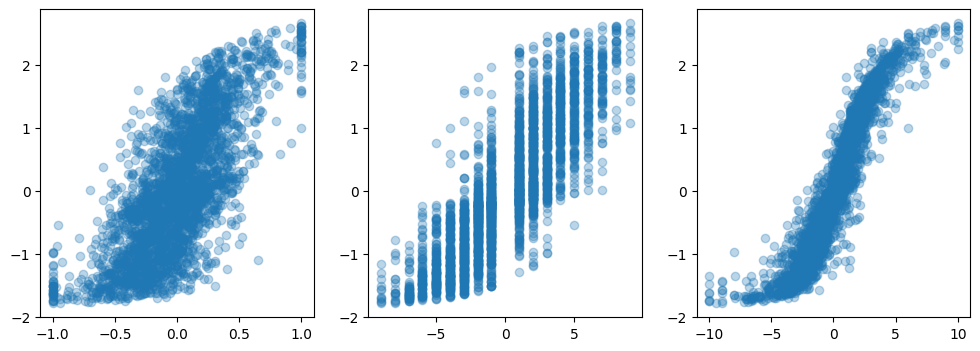

In [39]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 5] - X_test[:, 4], pred_v[:, 2] - pred_v[:, 1], alpha=0.3);

plt.subplot(132)
plt.scatter(X_test[:, 2] - X_test[:, 1], pred_v[:, 2] - pred_v[:, 1], alpha=0.3);

plt.subplot(133)
plt.scatter(X_test[:, 2]*X_test[:, 5] - X_test[:, 1]*X_test[:, 4], pred_v[:, 2] - pred_v[:, 1], alpha=0.3);

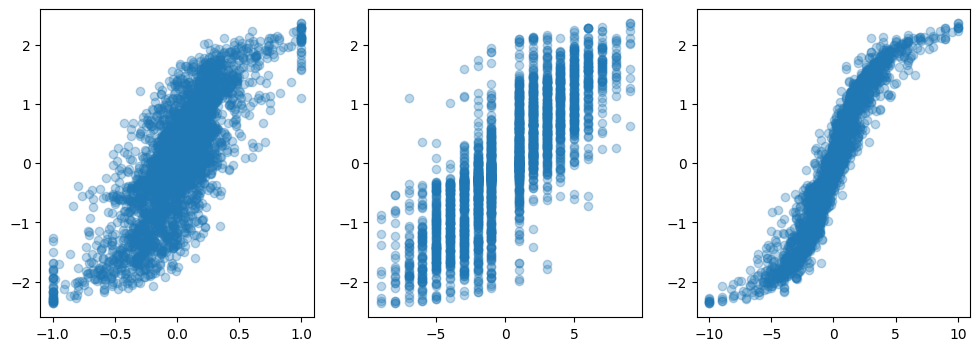

In [40]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 5] - X_test[:, 3], pred_v[:, 2] - pred_v[:, 0], alpha=0.3);

plt.subplot(132)
plt.scatter(X_test[:, 2] - X_test[:, 0], pred_v[:, 2] - pred_v[:, 0], alpha=0.3);

plt.subplot(133)
plt.scatter(X_test[:, 2]*X_test[:, 5] - X_test[:, 0]*X_test[:, 3], pred_v[:, 2] - pred_v[:, 0], alpha=0.3);


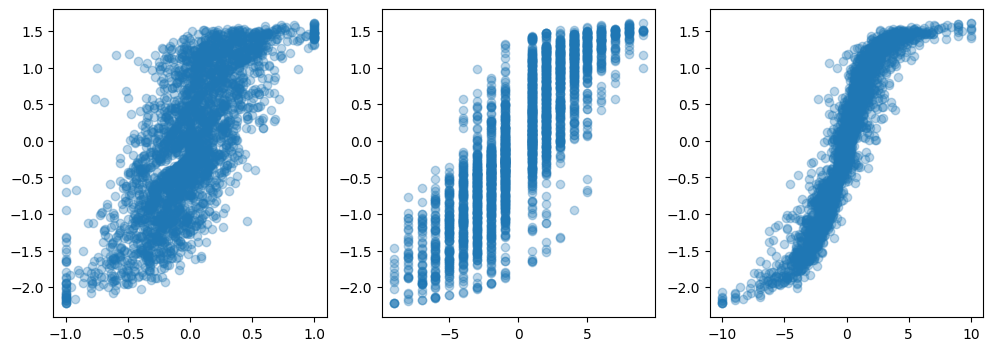

In [41]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 4] - X_test[:, 3], pred_v[:, 1] - pred_v[:, 0], alpha=0.3);

plt.subplot(132)
plt.scatter(X_test[:, 1] - X_test[:, 0], pred_v[:, 1] - pred_v[:, 0], alpha=0.3);

plt.subplot(133)
plt.scatter(X_test[:, 1]*X_test[:, 4] - X_test[:, 0]*X_test[:, 3], pred_v[:, 1] - pred_v[:, 0], alpha=0.3);
